# Introdution to Artificial Neural Networks with Keras

In [1]:
# FIXME: meke autocompletion working again
%config Completer.use_jedi = False

## The Perceptron
**Forward step** is $h_{\mathbf{W}, \mathbf{b}} = \phi(\mathbf{X}\mathbf{W} + \mathbf{b})$ (assuming the addition is broadcasted).

**Learning step** is $w_{i,j}^{(\text{next})} = w_{i,j} + \eta (y_j - \hat{y}_j) x_i$ where:
* $x_i$ is the $i$-th input
* $y_j$ is the $j$-th target
* $\hat{y}_j$ is the $j$-th predicted value
* $\eta$ is the learning rate

The learning is basically a gradient descent with constant learning rate and specific gradient.

It can be shown that for linearly separable dataset this algorightm converges and finds a separating hyper-plane.

In [2]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# Load the IRIS dataset
iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

# Train Perceptron with single unit
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

# Make a prediction
per_clf.predict([[2, 0.5]])

array([1])

## Activation functions

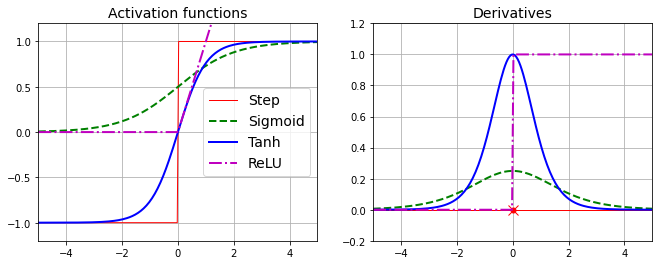

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

# Define the input space for activation functions
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

# Plot activation functions
plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

# Plot first derivatives (approx.) of activation functions above
plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

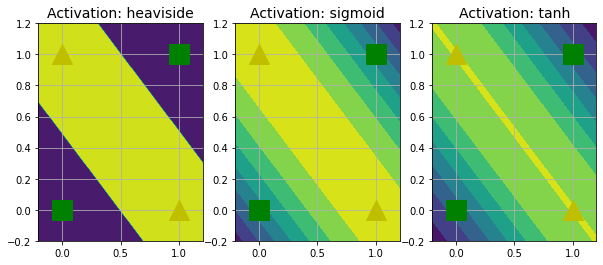

In [4]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

# Crate a space for the XOR problem
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

plt.figure(figsize=(10,4))

def plot_xor_activation(i, activation):
    # Plot contour of activation function on the XOR space
    plt.subplot(131 + i)
    plt.contourf(x1, x2, mlp_xor(x1, x2, activation))
    plt.plot([0, 1], [0, 1], "gs", markersize=20)
    plt.plot([0, 1], [1, 0], "y^", markersize=20)
    plt.title(f"Activation: {activation.__name__}", fontsize=14)
    plt.grid(True)

for i, activation in enumerate([heaviside, sigmoid, np.tanh]):
    plot_xor_activation(i, activation)

plt.show()

## Regression MLPs
* **Inputs**: one neuron per input feature
* **Outputs**: one neuron per output dimension
* **# hidden layers**: typically 1-5
* **# neurons per hidden layer**: typically 10-100
* **Activation in hidden layer**: *ReLU*
* **Activation in output layer**: None or *ReLU*/*softplus* (positive output) or *logistic*/*tanh* (interval bounded output)
* **Loss function**: *MSE* or *mean absolute error (MAE)* / *Huber loss* (if outliers)

## Classification MLPs
| Hyperparameter          | Binary classification | Multilabel binary classification | Multiclass classification |
|-------------------------|-----------------------|----------------------------------|---------------------------|
| Input and hidden layers | Sane as regression    | Same as regression               | Same as regression        |
| # output neurons        | 1                     | 1 per label                      | 1 per class               |
| Output layer activation | Logistic              | Logistic                         | Softmax                   |
| Loss function           | Cross entropy         | Cross entropy                    | Cross entropy             |

## Implementing MLPs with Keras
**Keras (multibackend)** was originally an open-source research project that defines a generic API for deep learning models that supports multiple execution backends:
* *theano*
* *mxnet*
* *tensorflow*

`tf.keras` is *TensorFlow*'s bundeled implementation of Keras (using TF backend of course) which comes with some extra TF features.

An alternative, but nowadays very similar, library is Facebook's **PyTorch**.

### Building an Image Classifier Using the Sequential API

In [5]:
import tensorflow as tf
from tensorflow import keras

# Load Fashin MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full.shape

(60000, 28, 28)

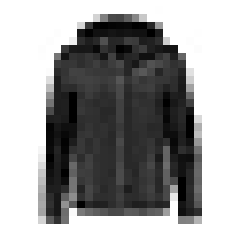

In [6]:
# Create a validation set and scale inputs to [0, 1] range
max_value = 255.0
val_train_split = 5000
X_valid, X_train = X_train_full[:val_train_split] / max_value, X_train_full[val_train_split:] / max_value
y_valid, y_train = y_train_full[:val_train_split], y_train_full[val_train_split:]
X_test = X_test / max_value

plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [8]:
# Define class names to be used for corresponding class labels
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

class_names[y_train[0]]

'Coat'

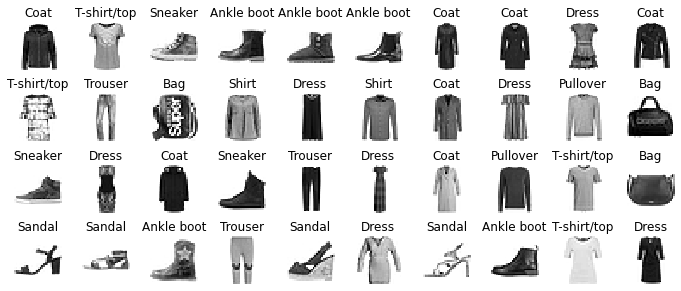

In [9]:
# Show some images

n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=input_shape))
model.add(keras.layers.Dense(300, activation=keras.activations.relu))
model.add(keras.layers.Dense(100, activation=keras.activations.relu))
model.add(keras.layers.Dense(10, activation=keras.activations.softmax))

In [11]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Equivalent to above, also activations can be referred to just by name, e.g. `"relu"`
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


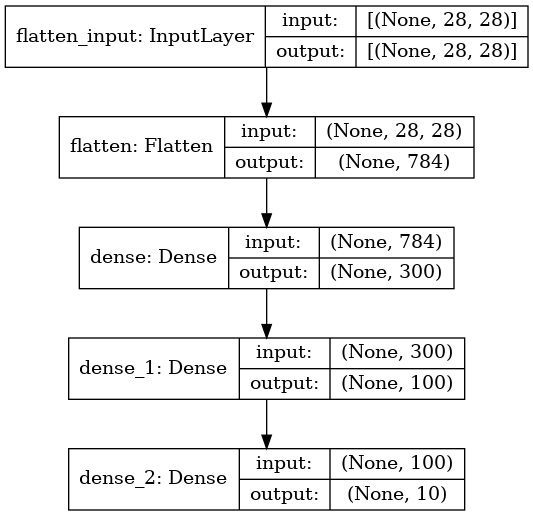

In [12]:
import os

keras.utils.plot_model(model, os.path.join("data", "my_fashion_mnist_model.png"), show_shapes=True)

In [13]:
model.layers

In [14]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [15]:
model.get_layer(hidden1.name) is hidden1

True

In [16]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [17]:
weights.shape

(784, 300)

In [18]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [19]:
biases.shape

(300,)

In [20]:
# Compile the model to set the loss function and other metadata
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"],
)

# Train the model on the trainng set for 30 epochs and validate on the validation set
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0187 - accuracy: 0.6805 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5028 - accuracy: 0.8262 - val_loss: 0.4351 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4484 - accuracy: 0.8421 - val_loss: 0.5363 - val_accuracy: 0.7984
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4210 - accuracy: 0.8525 - val_loss: 0.3914 - val_accuracy: 0.8652
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4060 - accuracy: 0.8580 - val_loss: 0.3744 - val_accuracy: 0.8696
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3753 - accuracy: 0.8676 - val_loss: 0.3713 - val_accuracy: 0.8726
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3654 - accuracy: 0.8707 - val_loss: 0.3613 - val_accuracy:

In [21]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [22]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

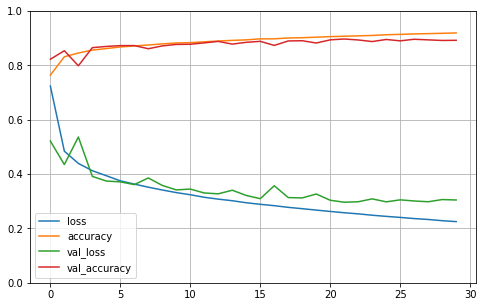

In [24]:
import pandas as pd

history_df = pd.DataFrame(history.history)

# Plot learning curves
history_df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3388 - accuracy: 0.8818


[0.3388163447380066, 0.8817999958992004]

In [26]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [27]:
# y_pred = model.predict_classes(X_new)  # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [28]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [29]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

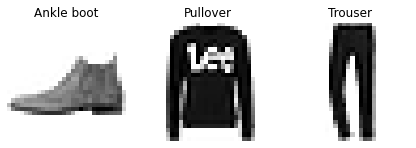

In [30]:
plt.figure(figsize=(7.2, 2.4))

for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Building a Regression MLP Using the Sequential API

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.2656 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7413 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6604 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6245 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5770 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5609 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5500 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5200 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5051 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4910 - val_loss: 0.4656

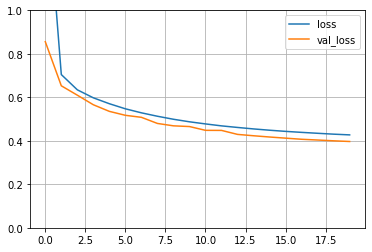

In [31]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the California housing dataset
#  - this one contains just numeric features and no missing values
housing = fetch_california_housing()

# Split the dateset to trainging, validation and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# Scale the inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Set state of the random number generator
np.random.seed(42)
tf.random.set_seed(42)

# Construct the sequential model with single hidden layer (ReLU) and single output neuron
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

# Compile the model - setting MSE as the loss function and SGD as the optimizer
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

# Train and validate the model for 20 epochs
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history_df = pd.DataFrame(history.history)

# Evaluate the model on the test set
mse_test = model.evaluate(X_test, y_test)

# Plot the learning curves
history_df.plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [32]:
# Make an example prediction on few test instances
X_new = X_test[:3]
model.predict(X_new)

array([[0.38856646],
       [1.6792021 ],
       [3.1022794 ]], dtype=float32)

## Functional API
This API can be used to build non-sequential network architectures. Examples below show models that have:
* input connected to hidden layers of different depths
* multiple inputs
* multiple outputs

This example architecture is called *Wide & Deep* network (used for instance in recommender systems) and provides a way how to
* learn both deep patterns (long path) and simple rules (short path)
* provide manually engineered features (additional input path)

In [33]:
# Set the random generator state
np.random.seed(42)
tf.random.set_seed(42)

# Functional API is useful when one needs to reference and connect specific layers
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

# e.g. here we create a hidden layer by concatenating input to the output of 2nd hidden layer
#  - notice that this is a functional construct which doesn't have any model parameters
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)

# To construct a model we specify which layer is the input and output
model = keras.models.Model(inputs=[input_], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

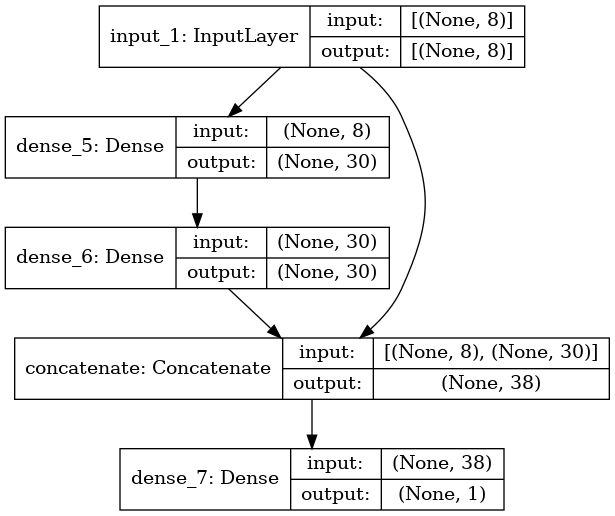

In [34]:
keras.utils.plot_model(model, os.path.join("data", "fashion_mnist_functional_1.png"), show_shapes=True)

In [35]:
# Build the model - setting MSE as the loss function and SGD as the optimizer
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

# Train and validate the model for 20 epochs
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Evaluate the model on the test set
mse_test = model.evaluate(X_test, y_test)

# Make a prediction on few test instances
model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.9731 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7638 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6045 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5862 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5452 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5243 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5185 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4947 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4782 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4708 - val_loss: 0.4313

array([[0.4701176],
       [1.873529 ],
       [3.3798187]], dtype=float32)

One can also tweak which features will go which path from the input to connected layers.

In [36]:
# Set the random generator state
np.random.seed(42)
tf.random.set_seed(42)

# Define not one but two inputs - "wide" and "deep"
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

# First hidden layer receives the "deep" input
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

# Second hidden layer is then concatenated with the "wide" input
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)

# Construct and build the model (MSE and SGD as before)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Split training and validation sets features-wise to inputs A and B
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

# Train and validate this model on (A, B) input pairs for 20 epochs
history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))

# Evaluate model on the test set - also with (A, B) inputs
mse_test = model.evaluate((X_test_A, X_test_B), y_test)

# And similarly make new predictions
model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 3.1941 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7247 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6176 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5799 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5409 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5173 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5186 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4977 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4765 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4676 - val_loss: 0.4315

array([[0.30591235],
       [1.9540672 ],
       [3.4426105 ]], dtype=float32)

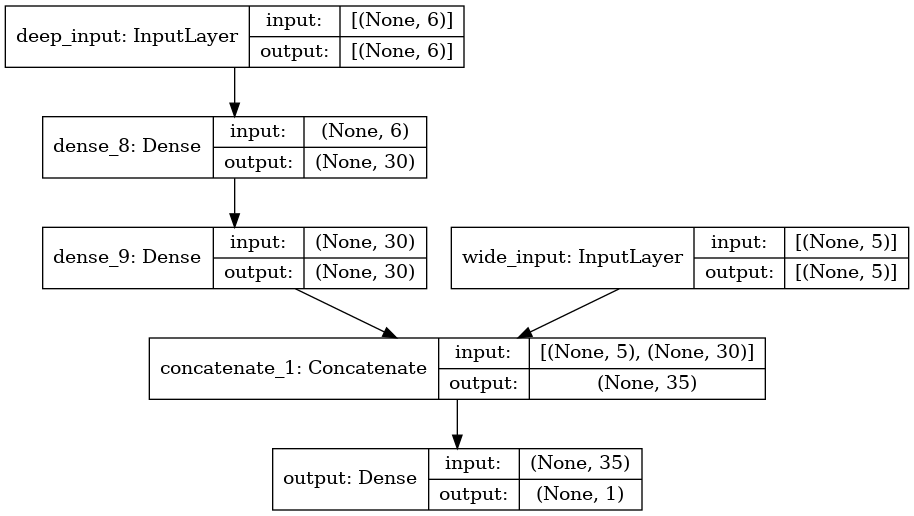

In [37]:
keras.utils.plot_model(model, os.path.join("data", "fashion_mnist_functional_2.png"), show_shapes=True)

It is also possible to add an auxiliary output for regularization. The idea here is that the underlying network (under the aux. output) should learn something useful on its own, thus removing some degrees of freedom for the whole network.

Alternative usecase of additional outputs is to perform *multi-task* learning - for instance, locating a face in a picture (outputs: center coordinates, width and height of the bnounding box) as well as classifying whether he/she is smiling or not. Of course it is possible to train two separate networks with single output each but typically having single network learning multiple tasks has better results (knowledge learned for one task can be transferred to the other one).

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 3.4633 - main_output_loss: 3.3289 - aux_output_loss: 4.6732 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.9807 - main_output_loss: 0.7503 - aux_output_loss: 3.0537 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7742 - main_output_loss: 0.6290 - aux_output_loss: 2.0810 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6952 - main_output_loss: 0.5897 - aux_output_loss: 1.6449 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6469 - main_output_loss: 0.5508 - aux_output_loss: 1.5118 - val_loss

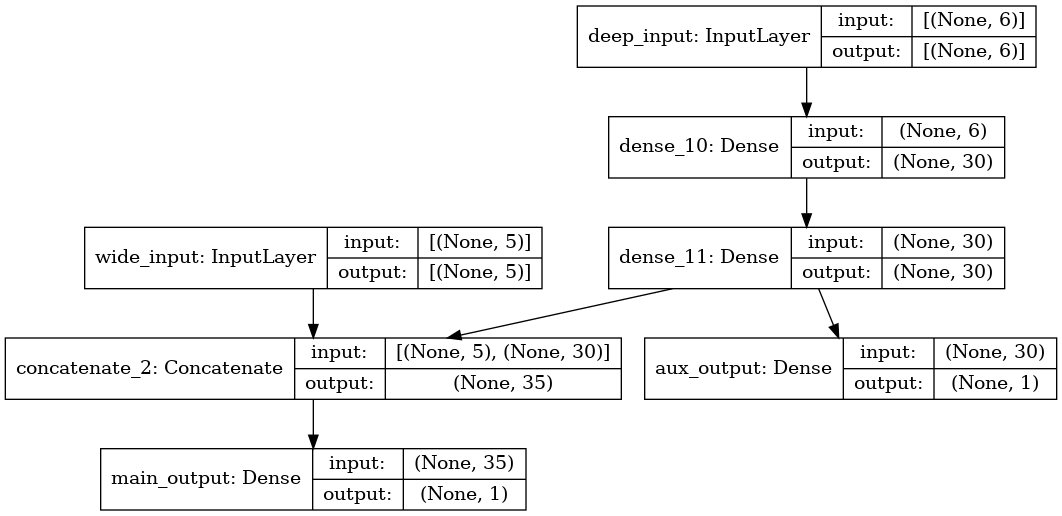

In [38]:
# Set the random generator state
np.random.seed(42)
tf.random.set_seed(42)

# Make two inputs as before
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

# And construct hidden layers in the same way
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])

# But make an aux. output for regularization (connected to the 2nd hidden layer)
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

# Construct and compile the model (SGD and MSE for both outputs with associated weights)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

# Train and validate the model - notice duplicated labels (due to double output)
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

# Due to multiple outputs we get multiple evaluations and predictions
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

# Plot the network architecture
keras.utils.plot_model(model, os.path.join("data", "fashion_mnist_functional_3.png"), show_shapes=True)

## The subclassing API
Provides dynamic network architectures with looping and conditional branching at the cost of runtime errors and lacking static analysis.

In [39]:
class WideAndDeepModel(keras.models.Model):
    
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

# Construct and compile the model
model = WideAndDeepModel(30, activation="relu")
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

# Train and validate the model
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10, validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

# Evaluate the model
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))

# Make new predictions
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

# Show limited summary
model.summary()

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 3.3855 - output_1_loss: 3.3304 - output_2_loss: 3.8821 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 1ms/step - loss: 1.0790 - output_1_loss: 0.9329 - output_2_loss: 2.3942 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.8644 - output_1_loss: 0.7583 - output_2_loss: 1.8194 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7850 - output_1_loss: 0.6979 - output_2_loss: 1.5689 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7294 - output_1_loss: 0.6499 - output_2_loss: 1.4452 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

## Saving and restoring a model
This method works for the *sequential* and *functional* APIs. Unfortunately this is **not supported** for the *subclassing* API, for which one can at least save/load model weights with `save_weights()`/`load_weights()` (architecture and hyper-parameters must be handled manually).

In [40]:
# Set the random number generator state
np.random.seed(42)
tf.random.set_seed(42)

# Build a sequential model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Train the model and evaluate it
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

# Finally save the model to HDF5 format
model_path = os.path.join("data", "my_keras_model.h5")
model.save(model_path)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 736us/step - loss: 0.4382


In [41]:
# Some time later, perhaps in a different process, load the model and make predictions
model = keras.models.load_model(model_path)
model.predict(X_new)

array([[0.5400236],
       [1.6505969],
       [3.009824 ]], dtype=float32)

In [42]:
# Save and load model weights
weights_path = os.path.join("data", "my_keras_weights.ckpt")
model.save_weights(weights_path)
model.load_weights(weights_path)

## Using Callbacks during Training

In [43]:
# Restart TF session and set RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Set path for model checkpoints
model_path = os.path.join("data", "checkpointed_keras_model.h5")

# Build a model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Setup callback saving the best model duting training
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])

# Rollback to the best model (from the checkpoint)
model = keras.models.load_model(model_path)
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 715us/step - loss: 0.4382


In [44]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Another pre-defined callback implements an early stopping strategy
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# With this strategy one can set no. epochs to a large number
#  - learning will stop when the error does not improve for `patience` steps
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb],
)

mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4578 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4430 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4376 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4361 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4204 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4112 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4226 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4135 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4039 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4023 - val_lo

In [45]:
# Finally, one can also define various custom callbacks
#  - this one displays ratio of validation to training error (per epoch)
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_data=(X_valid, y_valid),
    callbacks=[PrintValTrainRatioCallback()],
)

363/363 [==============================] - 0s 1ms/step - loss: 0.3302 - val_loss: 0.3561

val/train: 1.08


## Using TensorBoard for Visualization

In [46]:
import time

# Reset TF session and set RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Setup root log directory for TensorBoard
root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir(logdir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

# Get new log directory for current run
run_logdir = get_run_logdir(root_logdir)
run_logdir

'./logs/run_2021_01_17-13_46_53'

In [47]:
# Build a model in a standard fashion as presented before
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Fit the model using a TensorBoard callback pointing to the run's log dir
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, tensorboard_cb],
)

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4549 - val_loss: 0.4379

One can run **TensorBoard** server in a terminal like so
```bash
tensorboard --logdir=./logs --port=6006
```
help(keras.callbacks.TensorBoard.__init__)
Alternatively there is a jupyter extension which can be loaded as follows
```python
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006
```

In [48]:
run_logdir2 = get_run_logdir(root_logdir)
run_logdir2

'./logs/run_2021_01_17-13_47_06'

In [49]:
# Reset TF session and set RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Buld another model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

# Fit this model with TensorBoard callback pointing to the 2nd run
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, tensorboard_cb],
)

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.7645 - val_loss: 302.8545
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 666789.3596 - val_loss: 1.9514
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3439 - val_loss: 1.9451
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3546 - val_loss: 1.9549
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3513 - val_loss: 1.9421
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3274 - val_loss: 1.9483
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3639 - val_loss: 1.9413
Epoch 8/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3487 - val_loss: 1.9426
Epoch 9/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3445 - val_loss: 1.9414
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3697 - val_loss:

In [50]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



## Fine-Tuning Neural Network Hyperparameters

In [51]:
# Reset TF session and set RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    inputs = [keras.layers.InputLayer(input_shape=input_shape)]
    hidden = [keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_hidden)]
    outputs = [keras.layers.Dense(1)]
    model = keras.models.Sequential(inputs + hidden + outputs)
    model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=learning_rate))
    return model


# Build a Keras regression model and wrapped to Scikit-Learn adapter
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# Train the model
keras_reg.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 1.5673 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 1.3216 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5972 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4985 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4608 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4410 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4463 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4283 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4139 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4107 - val_l

In [52]:
# Compute and show Scikit-Learn's score (MSE of the model)
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 669us/step - loss: 0.3346


In [53]:
# Make new predictions
y_pred = keras_reg.predict(X_new)

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# Reset the RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Define hyperparameter space for tuning
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

# Run randomized 3-fold cross-validation as if the model was from Scikit-Learn
#  - note that `(X_valid, y_valid)` are used just for early stopping and not used by the CV
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2, n_jobs=-1)
rnd_search_cv.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

# Show score and hyperparameters of the best model
print("Best score %.3f\tBest params: %s" % (rnd_search_cv.best_score_, rnd_search_cv.best_params_))

# The test score is the negative of TF's total loss (MSE in this case)
#  - This is due to Scikit-Learn's "higher is better" philosophy
test_score = rnd_search_cv.score(X_test, y_test)
print("Test score: %.3f" % test_score)

# The underlying model is still a TF Keras model
model = rnd_search_cv.best_estimator_.model
test_mse = model.evaluate(X_test, y_test)
print("Test MSE: %.3f" % test_mse)

## Exercises

### Deep MLP on the MNIST dataset

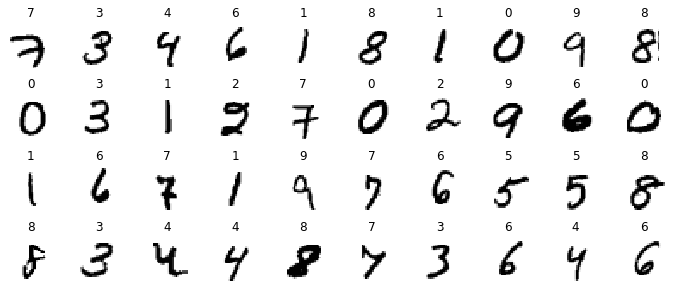

In [62]:
# Load the MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

# Create validation set and scale the inputs to [0, 1] interval
val_split = 5000
max_value = 255.
X_valid, X_train = X_train_full[:val_split] / max_value, X_train_full[val_split:] / max_value
y_valid, y_train = y_train_full[:val_split], y_train_full[val_split:]
X_test = X_test / max_value

# Show some training examples
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(y_train[index], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

1719/1719 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.4886 - val_loss: nan - val_accuracy: 0.0958


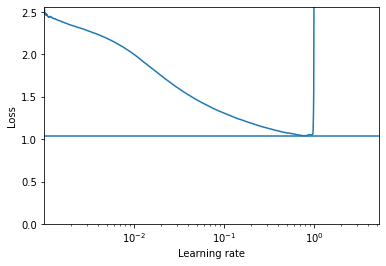

In [63]:
# Clear TF session and reset RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Define a callback to grow the learning rate at each iteration
class ExponentialLearningRate(keras.callbacks.Callback):

    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        # Record learning rate and loss at each iteration
        self.rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        # Set the next value of the learning rate (exponentially scaled)
        keras.backend.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

# Build a classification model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1e-3),
    metrics=["accuracy"],
)

# Train the model for 1 epoch while optimizing the learning rate
expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_data=(X_valid, y_valid),
    callbacks=[expon_lr],
)

# Plot the history of learning rates vs losses
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [64]:
# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Build new model with a learning rate found previously
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(lr=2e-1),
    metrics=["accuracy"],
)

# Setup run log and checkpoint paths
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "logs", "mnist", "run_{:03d}".format(run_index))
model_path = os.path.join("data", "mnist_model.h5")

# Setup callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# Train the model with early stopping strategy
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],
)

# Rollback to the best model
model = keras.models.load_model(model_path)

# Evaluate the model on the test set
model.evaluate(X_test, y_test)

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4178 - accuracy: 0.8704 - val_loss: 0.1024 - val_accuracy: 0.9684
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0948 - accuracy: 0.9708 - val_loss: 0.0874 - val_accuracy: 0.9762
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0673 - accuracy: 0.9789 - val_loss: 0.0718 - val_accuracy: 0.9796
Epoch 4/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0445 - accuracy: 0.9840 - val_loss: 0.0759 - val_accuracy: 0.9814
Epoch 5/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0323 - accuracy: 0.9898 - val_loss: 0.0729 - val_accuracy: 0.9798
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0268 - accuracy: 0.9906 - val_loss: 0.0723 - val_accuracy: 0.9820
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0672 - val_ac

[0.07222430408000946, 0.979200005531311]